<a href="https://colab.research.google.com/github/ronen-halevy/ai-notebooks/blob/main/notebooks/yolov3_yunyang194.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/YunYang1994/yymnist.git

Cloning into 'yymnist'...
remote: Enumerating objects: 65040, done.
remote: Total 65040 (delta 0), reused 0 (delta 0), pack-reused 65040
Receiving objects: 100% (65040/65040), 14.69 MiB | 14.75 MiB/s, done.
Resolving deltas: 100% (36315/36315), done.
Checking out files: 100% (65007/65007), done.


In [ ]:
# !rm -rf shapes-dataset
!pwd

/content/YOLOv3/YOLOv3


In [ ]:
!git clone https://github.com/ronen-halevy/shapes-dataset.git

In [ ]:
%cd YOLOv3

/content/YOLOv3/YOLOv3/YOLOv3


In [ ]:
from easydict import EasyDict as edict

__C                           = edict()
# Consumers can get config by: from config import cfg

cfg                           = __C

# YOLO options
__C.YOLO                      = edict()

# Set the class name
__C.YOLO.CLASSES              = "/content/YOLOv3/data/classes/yymnist.names"
__C.YOLO.ANCHORS              = "./data/anchors/basline_anchors.txt"
__C.YOLO.STRIDES              = [8, 16, 32]
__C.YOLO.ANCHOR_PER_SCALE     = 3
__C.YOLO.IOU_LOSS_THRESH      = 0.5

# Train options
__C.TRAIN                     = edict()

__C.TRAIN.ANNOT_PATH          = "/content/shapes-dataset/train/annotations/annotations.txt"
__C.TRAIN.BATCH_SIZE          = 2
# __C.TRAIN.INPUT_SIZE            = [320, 352, 384, 416, 448, 480, 512, 544, 576, 608]
__C.TRAIN.INPUT_SIZE          = [416]
__C.TRAIN.DATA_AUG            = True
__C.TRAIN.LR_INIT             = 1e-3
__C.TRAIN.LR_END              = 1e-6
__C.TRAIN.WARMUP_EPOCHS       = 2
__C.TRAIN.EPOCHS              = 5



# TEST options
__C.TEST                      = edict()

__C.TEST.ANNOT_PATH           = "/content/shapes-dataset/train/test/annotations/annotations.txt"
__C.TEST.BATCH_SIZE           = 2
__C.TEST.INPUT_SIZE           = 544
__C.TEST.DATA_AUG             = False
__C.TEST.DECTECTED_IMAGE_PATH = "./data/eval_detection/"
__C.TEST.SCORE_THRESHOLD      = 0.3
__C.TEST.IOU_THRESHOLD        = 0.45

##common.py

In [ ]:
import tensorflow as tf
class BatchNormalization(tf.keras.layers.BatchNormalization):
  """
  "Frozen state" and "inference mode" are two separate concepts.
    layer.trainable = False` is to freeze the layer, so the layer will use
    stored moving `var` and `mean` in the "inference mode", and both `gama`
    and `beta` will not be updated !
  """

  def call(self, x, training=False):
    if not training:
      training = tf.constant(False)
    training = tf.logical_and(training, self.trainable)
    return super().call(x, training)

class Common:
  @staticmethod
  def convolutional(input_layer, filters_shape, downsample=False, activate=True, bn=True):
      if downsample:
          input_layer = tf.keras.layers.ZeroPadding2D(((1, 0), (1, 0)))(input_layer)
          padding = 'valid'
          strides = 2
      else:
          strides = 1
          padding = 'same'

      conv = tf.keras.layers.Conv2D(filters=filters_shape[-1], kernel_size = filters_shape[0], strides=strides, padding=padding,
                                    use_bias=not bn, kernel_regularizer=tf.keras.regularizers.l2(0.0005),
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                                    bias_initializer=tf.constant_initializer(0.))(input_layer)

      if bn: conv = BatchNormalization()(conv)
      if activate == True: conv = tf.nn.leaky_relu(conv, alpha=0.1)

      return conv
  @staticmethod
  def residual_block(input_layer, input_channel, filter_num1, filter_num2):
      short_cut = input_layer
      conv = Common.convolutional(input_layer, filters_shape=(1, 1, input_channel, filter_num1))
      conv = Common.convolutional(conv       , filters_shape=(3, 3, filter_num1,   filter_num2))

      residual_output = short_cut + conv
      return residual_output
  
  @staticmethod
  def upsample(input_layer):
      return tf.image.resize(input_layer, (input_layer.shape[1] * 2, input_layer.shape[2] * 2), method='nearest')

##Utils

In [ ]:
import cv2
import random
import colorsys
import numpy as np
# from core.config import cfg

class Utils:
  
  @staticmethod
  def load_weights(model, weights_file):
      """
      I agree that this code is very ugly, but I don’t know any better way of doing it.
      """
      wf = open(weights_file, 'rb')
      major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

      j = 0
      for i in range(75):
          conv_layer_name = 'conv2d_%d' %i if i > 0 else 'conv2d'
          bn_layer_name = 'batch_normalization_%d' %j if j > 0 else 'batch_normalization'

          conv_layer = model.get_layer(conv_layer_name)
          filters = conv_layer.filters
          k_size = conv_layer.kernel_size[0]
          in_dim = conv_layer.input_shape[-1]

          if i not in [58, 66, 74]:
              # darknet weights: [beta, gamma, mean, variance]
              bn_weights = np.fromfile(wf, dtype=np.float32, count=4 * filters)
              # tf weights: [gamma, beta, mean, variance]
              bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]
              bn_layer = model.get_layer(bn_layer_name)
              j += 1
          else:
              conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)

          # darknet shape (out_dim, in_dim, height, width)
          conv_shape = (filters, in_dim, k_size, k_size)
          conv_weights = np.fromfile(wf, dtype=np.float32, count=np.product(conv_shape))
          # tf shape (height, width, in_dim, out_dim)
          conv_weights = conv_weights.reshape(conv_shape).transpose([2, 3, 1, 0])

          if i not in [58, 66, 74]:
              conv_layer.set_weights([conv_weights])
              bn_layer.set_weights(bn_weights)
          else:
              conv_layer.set_weights([conv_weights, conv_bias])

      assert len(wf.read()) == 0, 'failed to read all data'
      wf.close()

  @staticmethod
  def read_class_names(class_file_name):
      '''loads class name from a file'''
      names = {}
      with open(class_file_name, 'r') as data:
          for ID, name in enumerate(data):
              names[ID] = name.strip('\n')
      return names

  @staticmethod
  def get_anchors(anchors_path):
      '''loads the anchors from a file'''
      with open(anchors_path) as f:
          anchors = f.readline()
      anchors = np.array(anchors.split(','), dtype=np.float32)
      return anchors.reshape(3, 3, 2)


  @staticmethod
  def image_preporcess(image, target_size, gt_boxes=None):

      ih, iw    = target_size
      h,  w, _  = image.shape

      scale = min(iw/w, ih/h)
      nw, nh  = int(scale * w), int(scale * h)
      image_resized = cv2.resize(image, (nw, nh))

      image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
      dw, dh = (iw - nw) // 2, (ih-nh) // 2
      image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
      image_paded = image_paded / 255.

      if gt_boxes is None:
          return image_paded

      else:
          gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale + dw
          gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale + dh
          return image_paded, gt_boxes

  @staticmethod
  def draw_bbox(image, bboxes, classes=None, show_label=True):
      """
      bboxes: [x_min, y_min, x_max, y_max, probability, cls_id] format coordinates.
      """ 

      classes=classes or Utils.read_class_names(cfg.YOLO.CLASSES)
      num_classes = len(classes)
      image_h, image_w, _ = image.shape
      hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
      colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
      colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

      random.seed(0)
      random.shuffle(colors)
      random.seed(None)

      for i, bbox in enumerate(bboxes):
          coor = np.array(bbox[:4], dtype=np.int32)
          fontScale = 0.5
          score = bbox[4]
          class_ind = int(bbox[5])
          bbox_color = colors[class_ind]
          bbox_thick = int(0.6 * (image_h + image_w) / 600)
          c1, c2 = (coor[0], coor[1]), (coor[2], coor[3])
          cv2.rectangle(image, c1, c2, bbox_color, bbox_thick)

          if show_label:
              bbox_mess = '%s: %.2f' % (classes[class_ind], score)
              t_size = cv2.getTextSize(bbox_mess, 0, fontScale, thickness=bbox_thick//2)[0]
              cv2.rectangle(image, c1, (c1[0] + t_size[0], c1[1] - t_size[1] - 3), bbox_color, -1)  # filled

              cv2.putText(image, bbox_mess, (c1[0], c1[1]-2), cv2.FONT_HERSHEY_SIMPLEX,
                          fontScale, (0, 0, 0), bbox_thick//2, lineType=cv2.LINE_AA)

      return image


  @staticmethod
  def bboxes_iou(boxes1, boxes2):

      boxes1 = np.array(boxes1)
      boxes2 = np.array(boxes2)

      boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
      boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

      left_up       = np.maximum(boxes1[..., :2], boxes2[..., :2])
      right_down    = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

      inter_section = np.maximum(right_down - left_up, 0.0)
      inter_area    = inter_section[..., 0] * inter_section[..., 1]
      union_area    = boxes1_area + boxes2_area - inter_area
      ious          = np.maximum(1.0 * inter_area / union_area, np.finfo(np.float32).eps)

      return ious

  @staticmethod
  def nms(bboxes, iou_threshold, sigma=0.3, method='nms'):
      """
      :param bboxes: (xmin, ymin, xmax, ymax, score, class)
      Note: soft-nms, https://arxiv.org/pdf/1704.04503.pdf
            https://github.com/bharatsingh430/soft-nms
      """
      classes_in_img = list(set(bboxes[:, 5]))
      best_bboxes = []

      for cls in classes_in_img:
          cls_mask = (bboxes[:, 5] == cls)
          cls_bboxes = bboxes[cls_mask]

          while len(cls_bboxes) > 0:
              max_ind = np.argmax(cls_bboxes[:, 4])
              best_bbox = cls_bboxes[max_ind]
              best_bboxes.append(best_bbox)
              cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
              iou = Utils.bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
              weight = np.ones((len(iou),), dtype=np.float32)

              assert method in ['nms', 'soft-nms']

              if method == 'nms':
                  iou_mask = iou > iou_threshold
                  weight[iou_mask] = 0.0

              if method == 'soft-nms':
                  weight = np.exp(-(1.0 * iou ** 2 / sigma))

              cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
              score_mask = cls_bboxes[:, 4] > 0.
              cls_bboxes = cls_bboxes[score_mask]

      return best_bboxes

  @staticmethod
  def postprocess_boxes(pred_bbox, org_img_shape, input_size, score_threshold):

      valid_scale=[0, np.inf]
      pred_bbox = np.array(pred_bbox)

      pred_xywh = pred_bbox[:, 0:4]
      pred_conf = pred_bbox[:, 4]
      pred_prob = pred_bbox[:, 5:]

      # # (1) (x, y, w, h) --> (xmin, ymin, xmax, ymax)
      pred_coor = np.concatenate([pred_xywh[:, :2] - pred_xywh[:, 2:] * 0.5,
                                  pred_xywh[:, :2] + pred_xywh[:, 2:] * 0.5], axis=-1)
      # # (2) (xmin, ymin, xmax, ymax) -> (xmin_org, ymin_org, xmax_org, ymax_org)
      org_h, org_w = org_img_shape
      resize_ratio = min(input_size / org_w, input_size / org_h)

      dw = (input_size - resize_ratio * org_w) / 2
      dh = (input_size - resize_ratio * org_h) / 2

      pred_coor[:, 0::2] = 1.0 * (pred_coor[:, 0::2] - dw) / resize_ratio
      pred_coor[:, 1::2] = 1.0 * (pred_coor[:, 1::2] - dh) / resize_ratio

      # # (3) clip some boxes those are out of range
      pred_coor = np.concatenate([np.maximum(pred_coor[:, :2], [0, 0]),
                                  np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1])], axis=-1)
      invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
      pred_coor[invalid_mask] = 0

      # # (4) discard some invalid boxes
      bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
      scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

      # # (5) discard some boxes with low scores
      classes = np.argmax(pred_prob, axis=-1)
      scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
      score_mask = scores > score_threshold
      mask = np.logical_and(scale_mask, score_mask)
      coors, scores, classes = pred_coor[mask], scores[mask], classes[mask]

      return np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)

##dataset.py

In [ ]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
# import core.utils as utils
# from core.config import cfg

utils=Utils()

class Dataset(object):
    """implement Dataset here"""
    def __init__(self, dataset_type):
        self.annot_path  = cfg.TRAIN.ANNOT_PATH if dataset_type == 'train' else cfg.TEST.ANNOT_PATH
        self.input_sizes = cfg.TRAIN.INPUT_SIZE if dataset_type == 'train' else cfg.TEST.INPUT_SIZE
        self.batch_size  = cfg.TRAIN.BATCH_SIZE if dataset_type == 'train' else cfg.TEST.BATCH_SIZE
        self.data_aug    = cfg.TRAIN.DATA_AUG   if dataset_type == 'train' else cfg.TEST.DATA_AUG

        self.train_input_sizes = cfg.TRAIN.INPUT_SIZE
        self.strides = np.array(cfg.YOLO.STRIDES)
        self.classes = utils.read_class_names(cfg.YOLO.CLASSES)
        self.num_classes = len(self.classes)
        self.anchors = np.array(utils.get_anchors(cfg.YOLO.ANCHORS))
        self.anchor_per_scale = cfg.YOLO.ANCHOR_PER_SCALE
        self.max_bbox_per_scale = 150

        self.annotations = self.load_annotations(dataset_type)
        self.num_samples = len(self.annotations)
        self.num_batchs = int(np.ceil(self.num_samples / self.batch_size))
        self.batch_count = 0


    def load_annotations(self, dataset_type):
        with open(self.annot_path, 'r') as f:
            txt = f.readlines()
            annotations = [line.strip() for line in txt if len(line.strip().split()[1:]) != 0]
        np.random.shuffle(annotations)
        return annotations

    def __iter__(self):
        return self

    def __next__(self):

        with tf.device('/cpu:0'):
            self.train_input_size = random.choice(self.train_input_sizes)
            self.train_output_sizes = self.train_input_size // self.strides

            batch_image = np.zeros((self.batch_size, self.train_input_size, self.train_input_size, 3), dtype=np.float32)

            batch_label_sbbox = np.zeros((self.batch_size, self.train_output_sizes[0], self.train_output_sizes[0],
                                          self.anchor_per_scale, 5 + self.num_classes), dtype=np.float32)
            batch_label_mbbox = np.zeros((self.batch_size, self.train_output_sizes[1], self.train_output_sizes[1],
                                          self.anchor_per_scale, 5 + self.num_classes), dtype=np.float32)
            batch_label_lbbox = np.zeros((self.batch_size, self.train_output_sizes[2], self.train_output_sizes[2],
                                          self.anchor_per_scale, 5 + self.num_classes), dtype=np.float32)

            batch_sbboxes = np.zeros((self.batch_size, self.max_bbox_per_scale, 4), dtype=np.float32)
            batch_mbboxes = np.zeros((self.batch_size, self.max_bbox_per_scale, 4), dtype=np.float32)
            batch_lbboxes = np.zeros((self.batch_size, self.max_bbox_per_scale, 4), dtype=np.float32)

            num = 0
            if self.batch_count < self.num_batchs:
                while num < self.batch_size:
                    index = self.batch_count * self.batch_size + num
                    if index >= self.num_samples: index -= self.num_samples
                    annotation = self.annotations[index]
                    image, bboxes = self.parse_annotation(annotation)
                    label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes = self.preprocess_true_boxes(bboxes)

                    batch_image[num, :, :, :] = image
                    batch_label_sbbox[num, :, :, :, :] = label_sbbox
                    batch_label_mbbox[num, :, :, :, :] = label_mbbox
                    batch_label_lbbox[num, :, :, :, :] = label_lbbox
                    batch_sbboxes[num, :, :] = sbboxes
                    batch_mbboxes[num, :, :] = mbboxes
                    batch_lbboxes[num, :, :] = lbboxes
                    num += 1
                self.batch_count += 1
                batch_smaller_target = batch_label_sbbox, batch_sbboxes
                batch_medium_target  = batch_label_mbbox, batch_mbboxes
                batch_larger_target  = batch_label_lbbox, batch_lbboxes

                return batch_image, (batch_smaller_target, batch_medium_target, batch_larger_target)
            else:
                self.batch_count = 0
                np.random.shuffle(self.annotations)
                raise StopIteration

    def random_horizontal_flip(self, image, bboxes):

        if random.random() < 0.5:
            _, w, _ = image.shape
            image = image[:, ::-1, :]
            bboxes[:, [0,2]] = w - bboxes[:, [2,0]]

        return image, bboxes

    def random_crop(self, image, bboxes):

        if random.random() < 0.5:
            h, w, _ = image.shape
            max_bbox = np.concatenate([np.min(bboxes[:, 0:2], axis=0), np.max(bboxes[:, 2:4], axis=0)], axis=-1)

            max_l_trans = max_bbox[0]
            max_u_trans = max_bbox[1]
            max_r_trans = w - max_bbox[2]
            max_d_trans = h - max_bbox[3]

            crop_xmin = max(0, int(max_bbox[0] - random.uniform(0, max_l_trans)))
            crop_ymin = max(0, int(max_bbox[1] - random.uniform(0, max_u_trans)))
            crop_xmax = max(w, int(max_bbox[2] + random.uniform(0, max_r_trans)))
            crop_ymax = max(h, int(max_bbox[3] + random.uniform(0, max_d_trans)))

            image = image[crop_ymin : crop_ymax, crop_xmin : crop_xmax]

            bboxes[:, [0, 2]] = bboxes[:, [0, 2]] - crop_xmin
            bboxes[:, [1, 3]] = bboxes[:, [1, 3]] - crop_ymin

        return image, bboxes

    def random_translate(self, image, bboxes):

        if random.random() < 0.5:
            h, w, _ = image.shape
            max_bbox = np.concatenate([np.min(bboxes[:, 0:2], axis=0), np.max(bboxes[:, 2:4], axis=0)], axis=-1)

            max_l_trans = max_bbox[0]
            max_u_trans = max_bbox[1]
            max_r_trans = w - max_bbox[2]
            max_d_trans = h - max_bbox[3]

            tx = random.uniform(-(max_l_trans - 1), (max_r_trans - 1))
            ty = random.uniform(-(max_u_trans - 1), (max_d_trans - 1))

            M = np.array([[1, 0, tx], [0, 1, ty]])
            image = cv2.warpAffine(image, M, (w, h))

            bboxes[:, [0, 2]] = bboxes[:, [0, 2]] + tx
            bboxes[:, [1, 3]] = bboxes[:, [1, 3]] + ty

        return image, bboxes

    def parse_annotation(self, annotation):

        line = annotation.split()
        image_path = line[0]
        if not os.path.exists(image_path):
            raise KeyError("%s does not exist ... " %image_path)
        image = cv2.imread(image_path)
        bboxes = np.array([list(map(int, box.split(','))) for box in line[1:]])

        if self.data_aug:
            image, bboxes = self.random_horizontal_flip(np.copy(image), np.copy(bboxes))
            image, bboxes = self.random_crop(np.copy(image), np.copy(bboxes))
            image, bboxes = self.random_translate(np.copy(image), np.copy(bboxes))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image, bboxes = utils.image_preporcess(np.copy(image), [self.train_input_size, self.train_input_size], np.copy(bboxes))
        return image, bboxes

    def bbox_iou(self, boxes1, boxes2):

        boxes1 = np.array(boxes1)
        boxes2 = np.array(boxes2)

        boxes1_area = boxes1[..., 2] * boxes1[..., 3]
        boxes2_area = boxes2[..., 2] * boxes2[..., 3]

        boxes1 = np.concatenate([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                                boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
        boxes2 = np.concatenate([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                                boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

        left_up = np.maximum(boxes1[..., :2], boxes2[..., :2])
        right_down = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

        inter_section = np.maximum(right_down - left_up, 0.0)
        inter_area = inter_section[..., 0] * inter_section[..., 1]
        union_area = boxes1_area + boxes2_area - inter_area

        return inter_area / union_area

    def preprocess_true_boxes(self, bboxes):

        label = [np.zeros((self.train_output_sizes[i], self.train_output_sizes[i], self.anchor_per_scale,
                           5 + self.num_classes)) for i in range(3)]
        bboxes_xywh = [np.zeros((self.max_bbox_per_scale, 4)) for _ in range(3)]
        bbox_count = np.zeros((3,))

        for bbox in bboxes:
            bbox_coor = bbox[:4]
            bbox_class_ind = bbox[4]

            onehot = np.zeros(self.num_classes, dtype=np.float)
            onehot[bbox_class_ind] = 1.0
            uniform_distribution = np.full(self.num_classes, 1.0 / self.num_classes)
            deta = 0.01
            smooth_onehot = onehot * (1 - deta) + deta * uniform_distribution

            bbox_xywh = np.concatenate([(bbox_coor[2:] + bbox_coor[:2]) * 0.5, bbox_coor[2:] - bbox_coor[:2]], axis=-1)
            bbox_xywh_scaled = 1.0 * bbox_xywh[np.newaxis, :] / self.strides[:, np.newaxis]

            iou = []
            exist_positive = False
            for i in range(3):
                anchors_xywh = np.zeros((self.anchor_per_scale, 4))
                anchors_xywh[:, 0:2] = np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32) + 0.5
                anchors_xywh[:, 2:4] = self.anchors[i]

                iou_scale = self.bbox_iou(bbox_xywh_scaled[i][np.newaxis, :], anchors_xywh)
                iou.append(iou_scale)
                iou_mask = iou_scale > 0.3

                if np.any(iou_mask):
                    xind, yind = np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32)

                    label[i][yind, xind, iou_mask, :] = 0
                    label[i][yind, xind, iou_mask, 0:4] = bbox_xywh
                    label[i][yind, xind, iou_mask, 4:5] = 1.0
                    label[i][yind, xind, iou_mask, 5:] = smooth_onehot

                    bbox_ind = int(bbox_count[i] % self.max_bbox_per_scale)
                    bboxes_xywh[i][bbox_ind, :4] = bbox_xywh
                    bbox_count[i] += 1

                    exist_positive = True

            if not exist_positive:
                best_anchor_ind = np.argmax(np.array(iou).reshape(-1), axis=-1)
                best_detect = int(best_anchor_ind / self.anchor_per_scale)
                best_anchor = int(best_anchor_ind % self.anchor_per_scale)
                xind, yind = np.floor(bbox_xywh_scaled[best_detect, 0:2]).astype(np.int32)

                label[best_detect][yind, xind, best_anchor, :] = 0
                label[best_detect][yind, xind, best_anchor, 0:4] = bbox_xywh
                label[best_detect][yind, xind, best_anchor, 4:5] = 1.0
                label[best_detect][yind, xind, best_anchor, 5:] = smooth_onehot

                bbox_ind = int(bbox_count[best_detect] % self.max_bbox_per_scale)
                bboxes_xywh[best_detect][bbox_ind, :4] = bbox_xywh
                bbox_count[best_detect] += 1
        label_sbbox, label_mbbox, label_lbbox = label
        sbboxes, mbboxes, lbboxes = bboxes_xywh
        return label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes

    def __len__(self):
        return self.num_batchs

##backbone.py

In [ ]:
# !pwd
# %cd YOLOv3

In [ ]:
import tensorflow as tf
# import core.common as common
common=Common()

class Backbone:
  @staticmethod
  def darknet53(input_data):

      input_data = common.convolutional(input_data, (3, 3,  3,  32))
      input_data = common.convolutional(input_data, (3, 3, 32,  64), downsample=True)

      for i in range(1):
          input_data = common.residual_block(input_data,  64,  32, 64)

      input_data = common.convolutional(input_data, (3, 3,  64, 128), downsample=True)

      for i in range(2):
          input_data = common.residual_block(input_data, 128,  64, 128)

      input_data = common.convolutional(input_data, (3, 3, 128, 256), downsample=True)

      for i in range(8):
          input_data = common.residual_block(input_data, 256, 128, 256)

      route_1 = input_data
      input_data = common.convolutional(input_data, (3, 3, 256, 512), downsample=True)

      for i in range(8):
          input_data = common.residual_block(input_data, 512, 256, 512)

      route_2 = input_data
      input_data = common.convolutional(input_data, (3, 3, 512, 1024), downsample=True)

      for i in range(4):
          input_data = common.residual_block(input_data, 1024, 512, 1024)

      return route_1, route_2, input_data

##yolov3

In [ ]:
import numpy as np
import tensorflow as tf
# import core.utils as utils
# import core.common as common
# import core.backbone as backbone
# from core.config import cfg

backbone = Backbone()

NUM_CLASS       = len(utils.read_class_names(cfg.YOLO.CLASSES))
ANCHORS         = utils.get_anchors(cfg.YOLO.ANCHORS)
STRIDES         = np.array(cfg.YOLO.STRIDES)
IOU_LOSS_THRESH = cfg.YOLO.IOU_LOSS_THRESH

def YOLOv3(input_layer):
    route_1, route_2, conv = backbone.darknet53(input_layer)

    conv = common.convolutional(conv, (1, 1, 1024,  512))
    conv = common.convolutional(conv, (3, 3,  512, 1024))
    conv = common.convolutional(conv, (1, 1, 1024,  512))
    conv = common.convolutional(conv, (3, 3,  512, 1024))
    conv = common.convolutional(conv, (1, 1, 1024,  512))

    conv_lobj_branch = common.convolutional(conv, (3, 3, 512, 1024))
    conv_lbbox = common.convolutional(conv_lobj_branch, (1, 1, 1024, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = common.convolutional(conv, (1, 1,  512,  256))
    conv = common.upsample(conv)

    conv = tf.concat([conv, route_2], axis=-1)

    conv = common.convolutional(conv, (1, 1, 768, 256))
    conv = common.convolutional(conv, (3, 3, 256, 512))
    conv = common.convolutional(conv, (1, 1, 512, 256))
    conv = common.convolutional(conv, (3, 3, 256, 512))
    conv = common.convolutional(conv, (1, 1, 512, 256))

    conv_mobj_branch = common.convolutional(conv, (3, 3, 256, 512))
    conv_mbbox = common.convolutional(conv_mobj_branch, (1, 1, 512, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = common.convolutional(conv, (1, 1, 256, 128))
    conv = common.upsample(conv)

    conv = tf.concat([conv, route_1], axis=-1)

    conv = common.convolutional(conv, (1, 1, 384, 128))
    conv = common.convolutional(conv, (3, 3, 128, 256))
    conv = common.convolutional(conv, (1, 1, 256, 128))
    conv = common.convolutional(conv, (3, 3, 128, 256))
    conv = common.convolutional(conv, (1, 1, 256, 128))

    conv_sobj_branch = common.convolutional(conv, (3, 3, 128, 256))
    conv_sbbox = common.convolutional(conv_sobj_branch, (1, 1, 256, 3*(NUM_CLASS +5)), activate=False, bn=False)

    return [conv_sbbox, conv_mbbox, conv_lbbox]

def decode(conv_output, i=0):
    """
    return tensor of shape [batch_size, output_size, output_size, anchor_per_scale, 5 + num_classes]
            contains (x, y, w, h, score, probability)
    """

    conv_shape       = tf.shape(conv_output)
    batch_size       = conv_shape[0]
    output_size      = conv_shape[1]

    conv_output = tf.reshape(conv_output, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_dxdy = conv_output[:, :, :, :, 0:2]
    conv_raw_dwdh = conv_output[:, :, :, :, 2:4]
    conv_raw_conf = conv_output[:, :, :, :, 4:5]
    conv_raw_prob = conv_output[:, :, :, :, 5: ]

    y = tf.tile(tf.range(output_size, dtype=tf.int32)[:, tf.newaxis], [1, output_size])
    x = tf.tile(tf.range(output_size, dtype=tf.int32)[tf.newaxis, :], [output_size, 1])

    xy_grid = tf.concat([x[:, :, tf.newaxis], y[:, :, tf.newaxis]], axis=-1)
    xy_grid = tf.tile(xy_grid[tf.newaxis, :, :, tf.newaxis, :], [batch_size, 1, 1, 3, 1])
    xy_grid = tf.cast(xy_grid, tf.float32)

    pred_xy = (tf.sigmoid(conv_raw_dxdy) + xy_grid) * STRIDES[i]
    pred_wh = (tf.exp(conv_raw_dwdh) * ANCHORS[i]) * STRIDES[i]
    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)
    
    # tf.print('pred_wh', pred_wh, 'conv_raw_dwdh', conv_raw_dwdh, 'i', i, ANCHORS[i],  STRIDES[i])
    tf.print(STRIDES[i])

    pred_conf = tf.sigmoid(conv_raw_conf)
    pred_prob = tf.sigmoid(conv_raw_prob)

    return tf.concat([pred_xywh, pred_conf, pred_prob], axis=-1)

def bbox_iou(boxes1, boxes2):

    boxes1_area = boxes1[..., 2] * boxes1[..., 3]
    boxes2_area = boxes2[..., 2] * boxes2[..., 3]

    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area

    return 1.0 * inter_area / union_area

def bbox_giou(boxes1, boxes2):

    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    boxes1 = tf.concat([tf.minimum(boxes1[..., :2], boxes1[..., 2:]),
                        tf.maximum(boxes1[..., :2], boxes1[..., 2:])], axis=-1)
    boxes2 = tf.concat([tf.minimum(boxes2[..., :2], boxes2[..., 2:]),
                        tf.maximum(boxes2[..., :2], boxes2[..., 2:])], axis=-1)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area
    iou = inter_area / union_area

    enclose_left_up = tf.minimum(boxes1[..., :2], boxes2[..., :2])
    enclose_right_down = tf.maximum(boxes1[..., 2:], boxes2[..., 2:])
    enclose = tf.maximum(enclose_right_down - enclose_left_up, 0.0)
    enclose_area = enclose[..., 0] * enclose[..., 1]
    giou = iou - 1.0 * (enclose_area - union_area) / enclose_area

    return giou


def compute_loss(pred, conv, label, bboxes, i=0):

    conv_shape  = tf.shape(conv)
    batch_size  = conv_shape[0]
    output_size = conv_shape[1]
    input_size  = STRIDES[i] * output_size
    conv = tf.reshape(conv, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_conf = conv[:, :, :, :, 4:5]
    conv_raw_prob = conv[:, :, :, :, 5:]

    pred_xywh     = pred[:, :, :, :, 0:4]
    pred_conf     = pred[:, :, :, :, 4:5]

    label_xywh    = label[:, :, :, :, 0:4]
    respond_bbox  = label[:, :, :, :, 4:5]
    label_prob    = label[:, :, :, :, 5:]

    giou = tf.expand_dims(bbox_giou(pred_xywh, label_xywh), axis=-1)
    input_size = tf.cast(input_size, tf.float32)

    bbox_loss_scale = 2.0 - 1.0 * label_xywh[:, :, :, :, 2:3] * label_xywh[:, :, :, :, 3:4] / (input_size ** 2)
    giou_loss = respond_bbox * bbox_loss_scale * (1- giou)

    iou = bbox_iou(pred_xywh[:, :, :, :, np.newaxis, :], bboxes[:, np.newaxis, np.newaxis, np.newaxis, :, :])
    max_iou = tf.expand_dims(tf.reduce_max(iou, axis=-1), axis=-1)

    respond_bgd = (1.0 - respond_bbox) * tf.cast( max_iou < IOU_LOSS_THRESH, tf.float32 )

    conf_focal = tf.pow(respond_bbox - pred_conf, 2)

    conf_loss = conf_focal * (
            respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
            +
            respond_bgd * tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
    )

    prob_loss = respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=label_prob, logits=conv_raw_prob)

    giou_loss = tf.reduce_mean(tf.reduce_sum(giou_loss, axis=[1,2,3,4]))
    conf_loss = tf.reduce_mean(tf.reduce_sum(conf_loss, axis=[1,2,3,4]))
    prob_loss = tf.reduce_mean(tf.reduce_sum(prob_loss, axis=[1,2,3,4]))

    return giou_loss, conf_loss, prob_loss

#Train

In [ ]:
import os
import time
import shutil
import numpy as np
import tensorflow as tf
# import core.utils as utils
from tqdm import tqdm
# from core.dataset import Dataset
# from core.yolov3 import YOLOv3, decode, compute_loss
# from core.config import cfg

trainset = Dataset('train')
logdir = "./data/log"
steps_per_epoch = len(trainset)
global_steps = tf.Variable(1, trainable=False, dtype=tf.int64)
warmup_steps = cfg.TRAIN.WARMUP_EPOCHS * steps_per_epoch
total_steps = cfg.TRAIN.EPOCHS * steps_per_epoch

input_tensor = tf.keras.layers.Input([416, 416, 3])
conv_tensors = YOLOv3(input_tensor)

output_tensors = []
for i, conv_tensor in enumerate(conv_tensors):
    pred_tensor = decode(conv_tensor, i)
    output_tensors.append(conv_tensor)
    output_tensors.append(pred_tensor)

model = tf.keras.Model(input_tensor, output_tensors)
optimizer = tf.keras.optimizers.Adam()
if os.path.exists(logdir): shutil.rmtree(logdir)
writer = tf.summary.create_file_writer(logdir)

def train_step(image_data, target):
    with tf.GradientTape() as tape:
        pred_result = model(image_data, training=True)
        giou_loss=conf_loss=prob_loss=0

        # optimizing process
        for i in range(3):
            conv, pred = pred_result[i*2], pred_result[i*2+1]
            loss_items = compute_loss(pred, conv, *target[i], i)
            giou_loss += loss_items[0]
            conf_loss += loss_items[1]
            prob_loss += loss_items[2]

        total_loss = giou_loss + conf_loss + prob_loss

        gradients = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        tf.print("=> STEP %4d   lr: %.6f   giou_loss: %4.2f   conf_loss: %4.2f   "
                 "prob_loss: %4.2f   total_loss: %4.2f" %(global_steps, optimizer.lr.numpy(),
                                                          giou_loss, conf_loss,
                                                          prob_loss, total_loss))
        # update learning rate
        global_steps.assign_add(1)
        if global_steps < warmup_steps:
            lr = global_steps / warmup_steps *cfg.TRAIN.LR_INIT
        else:
            lr = cfg.TRAIN.LR_END + 0.5 * (cfg.TRAIN.LR_INIT - cfg.TRAIN.LR_END) * (
                (1 + tf.cos((global_steps - warmup_steps) / (total_steps - warmup_steps) * np.pi))
            )
        optimizer.lr.assign(lr.numpy())

        # writing summary data
        with writer.as_default():
            tf.summary.scalar("lr", optimizer.lr, step=global_steps)
            tf.summary.scalar("loss/total_loss", total_loss, step=global_steps)
            tf.summary.scalar("loss/giou_loss", giou_loss, step=global_steps)
            tf.summary.scalar("loss/conf_loss", conf_loss, step=global_steps)
            tf.summary.scalar("loss/prob_loss", prob_loss, step=global_steps)
        writer.flush()





8
16
32


In [ ]:
for epoch in range(cfg.TRAIN.EPOCHS):
    for image_data, target in trainset:
        train_step(image_data, target)
    model.save_weights("./yolov3")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:195: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Streaming output truncated to the last 5000 lines.
=> STEP 20001   lr: 0.000251   giou_loss: 2.01   conf_loss: 0.01   prob_loss: 2.35   total_loss: 4.36
=> STEP 20002   lr: 0.000251   giou_loss: 1.47   conf_loss: 0.00   prob_loss: 2.59   total_loss: 4.06
=> STEP 20003   lr: 0.000250   giou_loss: 1.77   conf_loss: 0.00   prob_loss: 2.22   total_loss: 3.99
=> STEP 20004   lr: 0.000250   giou_loss: 1.83   conf_loss: 0.01   prob_loss: 2.59   total_loss: 4.42
=> STEP 20005   lr: 0.000250   giou_loss: 2.00   conf_loss: 0.01   prob_loss: 2.83   total_loss: 4.84
=> STEP 20006   lr: 0.000250   giou_loss: 1.97   conf_loss: 0.00   prob_loss: 2.54   total_loss: 4.51
=> STEP 20007   lr: 0.000250   giou_loss: 1.90   conf_loss: 0.01   prob_loss: 2.47   total_loss: 4.38
=> STEP 20008   lr: 0.000250   giou_loss: 2.20   conf_loss: 0.01   prob_loss: 2.61   total_loss: 4.82
=> STEP 20009   lr: 0.000250   giou_loss: 1.24   conf_loss: 0.01   prob_loss: 2.53   total_loss: 3.78
=> STEP 20010   lr: 0.000250   

In [ ]:
model.save('my_shapes.h5', save_format='h5')
# WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


In [ ]:
!ls my*
!pwd

my_shapes  my_shapes.h5
/content/YOLOv3/YOLOv3/YOLOv3


#########################debug

[array([ 64.53570557,  87.13828278, 164.81129456, 287.14404297,
         0.9686203 ,   8.        ]), array([243.37167358, 329.16647339, 273.37759399, 389.01644897,
         0.96719199,   8.        ]), array([ 15.41194725, 299.94284058,  45.33998108, 359.87814331,
         0.96646875,   8.        ]), array([339.28930664,  31.08425522, 398.95770264,  60.97369003,
         0.97280157,   4.        ]), array([146.73504639, 360.9838562 , 206.55633545, 390.88327026,
         0.96576762,   4.        ]), array([238.38998413, 102.26548767, 338.95516968, 202.56126404,
         0.9704594 ,   6.        ]), array([313.43148804, 367.74102783, 343.48739624, 397.69055176,
         0.96487731,   6.        ])]
image_size =  (416, 416)


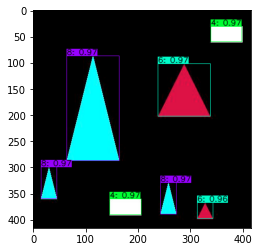

In [ ]:
import cv2
import os
import shutil
import numpy as np
import tensorflow as tf
# from core.config import cfg
import core.utils as utils
# import argparse


INPUT_SIZE = 416
SCORE_THRESHOLD = 0.7
IOU_THRESHOLD = 0.5

path_to_image  = '/content/shapes-dataset/valid/images/000009.jpg'
model = tf.keras.models.load_model('/content/YOLOv3/YOLOv3/YOLOv3/my_shapes.h5')

image = cv2.imread(path_to_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_size = image.shape[:2]
image_data = utils.image_preporcess(np.copy(image), [INPUT_SIZE, INPUT_SIZE])
image_data = image_data[np.newaxis, ...].astype(np.float32) # (1, width, height, 3)

pred_bbox = model.predict(image_data)
pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
pred_bbox = pred_bbox[1::2]
pred_bbox = tf.concat(pred_bbox, axis=0)
bboxes = utils.postprocess_boxes(pred_bbox, image_size, INPUT_SIZE, SCORE_THRESHOLD)
bboxes = utils.nms(bboxes, IOU_THRESHOLD, method='nms')
print(bboxes)

image_with_detections = utils.draw_bbox(image, bboxes)
import tensorflow as tf
import matplotlib.pyplot as plt
plt.imshow(image_with_detections)
# cv2.imshow('detections', image_with_detections)
# cv2.waitKey(0)
image_with_detections = cv2.cvtColor(image_with_detections, cv2.COLOR_RGB2BGR)
print('image_size = ', image_size)

    # If image size is too big then resize the image for display purposes
display_shape = (image_size[1], image_size[0])
if image_size[0] > 1500 or image_size[1] > 1500:
  display_shape = (int(image_size[1]/4), int(image_size[0]/4))

image_with_detections = cv2.resize(image_with_detections, display_shape)
import tensorflow as tf
import matplotlib.pyplot as plt
plt.imshow(image_with_detections)
# cv2.waitKey(0)

In [ ]:
for bbox in pred_bbox:
  print(bbox.shape)

(2704, 45)
(8112, 15)
(676, 45)
(2028, 15)
(169, 45)
(507, 15)


In [ ]:
print(pred_bbox)

[<tf.Tensor: shape=(2704, 45), dtype=float32, numpy=
array([[ -0.03411423,   0.08327127,  -0.04104217, ...,  -4.513093  ,
         -8.89036   ,  -8.673893  ],
       [ -0.01602428,   0.08666819,  -0.02625951, ...,  -3.4561906 ,
         -7.7900863 ,  -8.284527  ],
       [ -0.01566727,   0.094956  ,  -0.02744253, ...,  -3.1477048 ,
         -7.1178427 ,  -8.298087  ],
       ...,
       [ -0.10155766,   0.17461622,  -0.04577608, ...,  -6.356466  ,
         -4.2763414 ,  -7.8141494 ],
       [ -0.04837423,   0.18501839,  -0.05552084, ...,  -6.4889073 ,
         -6.971276  ,  -9.479306  ],
       [ -0.04512136,   0.14545187,  -0.08744401, ...,  -6.3033004 ,
         -7.9584775 , -10.3785095 ]], dtype=float32)>, <tf.Tensor: shape=(8112, 15), dtype=float32, numpy=
array([[3.9317782e+00, 4.1664462e+00, 9.5978870e+00, ..., 5.1312637e-01,
        5.1366818e-01, 4.9559316e-01],
       [4.8788314e+00, 2.6886423e+00, 3.4210388e+01, ..., 4.5453412e-03,
        1.0006784e-03, 1.0108125e-03],
     